### **Experimental Setup**
- Python (3.7.8)

### **Install Libraries**

In [317]:
# %pip install pandas
# %pip install numpy
# %pip install featuretools
# %pip install matplotlib
# %pip install scikit-learn

### **Constants**

In [318]:
import warnings
warnings.filterwarnings('ignore')

COMMODITY = 'copper'

# File paths
PETROL_FILE_PATH = '../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../../volza/{COMMODITY}/{COMMODITY}_prices.csv"
AIS_POPULAR_FILE_PATH = '../../ais/ais_ml_features.csv' 

# Columns
PRODUCT_NAME_COLUMN_NAME = 'product-name'
VOLZA_STD_QUANTITY_COLUMN_NAME = 'Std. Quantity'
VOLZA_VALUE_COLUMN_NAME = 'Value'

VOLZA_VALUE_COLUMN = 'Value'  
VOLZA_QUANTITY_COLUMN = 'Std. Quantity (POUND)'
VOLZA_UNIT_RATE_COLUMN = 'Std. Unit Rate ($/POUND)'


WTI_PRODUCT_NAME_LABEL = 'WTI Crude Oil'
BRENT_PRODUCT_NAME_LABEL = 'UK Brent Crude Oil'

SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20

### **Import data**

In [319]:
import pandas
from lib.preprocessing.volza import convert_to_pound  
# Load petrol data and then split into WTI and Brent
petrol_dataframe = pandas.read_csv(PETROL_FILE_PATH, sep=';', index_col='Date', parse_dates=True).sort_values(by='Date')
wti_petrol_dataframe = petrol_dataframe[petrol_dataframe[PRODUCT_NAME_COLUMN_NAME] == WTI_PRODUCT_NAME_LABEL][['Value']].sort_values(by='Date')
brent_petrol_dataframe = petrol_dataframe[petrol_dataframe[PRODUCT_NAME_COLUMN_NAME] == BRENT_PRODUCT_NAME_LABEL][['Value']].sort_values(by='Date')

volza_dataframe = pandas.read_csv(VOLZA_FILE_PATH, index_col='Date', parse_dates=True).sort_values(by='Date')
price_dataframe = pandas.read_csv(PRICE_FILE_PATH, index_col='Date', parse_dates=True).sort_values(by='Date')[['Price']]
ais_popular_dataframe = pandas.read_csv(AIS_POPULAR_FILE_PATH, index_col='Date', parse_dates=True).sort_values(by='Date')[['ship_count', 'popular_port_count']]

if COMMODITY == 'magnesium': price_dataframe['Price'] = price_dataframe['Price'].apply(lambda x: x.replace(',', '')).astype(float)

volza_dataframe = convert_to_pound(volza_dataframe)[[VOLZA_QUANTITY_COLUMN, VOLZA_UNIT_RATE_COLUMN]]
volza_dataframe = volza_dataframe.resample('D').mean().fillna(method='ffill')

# Remove extraneous values from volza_dataframe as these don't make sense
volza_dataframe = volza_dataframe[volza_dataframe[VOLZA_QUANTITY_COLUMN] < 100000]
volza_dataframe = volza_dataframe[volza_dataframe[VOLZA_UNIT_RATE_COLUMN] < 100000]
volza_dataframe

KeyError: "['Unnamed: 0'] not found in axis"

### **Feature Engineering**

In [ ]:
from lib.edcr.convert_to_boolean import number_to_boolean, convert_all_numbers_to_boolean
from lib.utils.numeric_range import drange

# ------------------ Convert to boolean ------------------
# Convert values to boolean to make it easier for EDCR
# --------------------------------------------------------
price_dataframe_edcr = convert_all_numbers_to_boolean(price_dataframe, 10)
wti_petrol_dataframe_edcr = convert_all_numbers_to_boolean(wti_petrol_dataframe, 10)
brent_petrol_dataframe_edcr = convert_all_numbers_to_boolean(brent_petrol_dataframe, 10)
volza_dataframe_edcr = convert_all_numbers_to_boolean(volza_dataframe, 100)

price_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_price.csv')
wti_petrol_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_wti_petrol.csv')
brent_petrol_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_brent_petrol.csv')
volza_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_volza.csv')

### Spike Identification
We use methods for identifying spikes. The ones we currently have availabe are:
- Z-score spike identification with rolling window: Takes the rolling mean of the entire time series and looks for values a certain rolling std.dev above it.

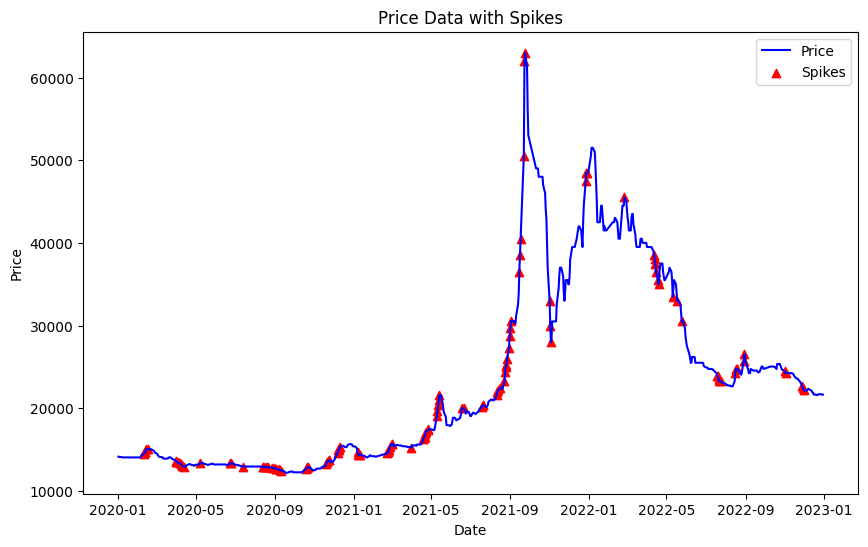

In [ ]:
from lib.spike_identification import z_score_spike_detection
import matplotlib.pyplot as plt

price_dataframe['spikes'] = z_score_spike_detection(price_dataframe['Price'], SPIKES_WINDOW_SIZE, SPIKES_THRESHOLD)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(price_dataframe.index, price_dataframe['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = price_dataframe[price_dataframe['spikes'] == 1].index
spike_prices = price_dataframe.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

<AxesSubplot:xlabel='Date'>

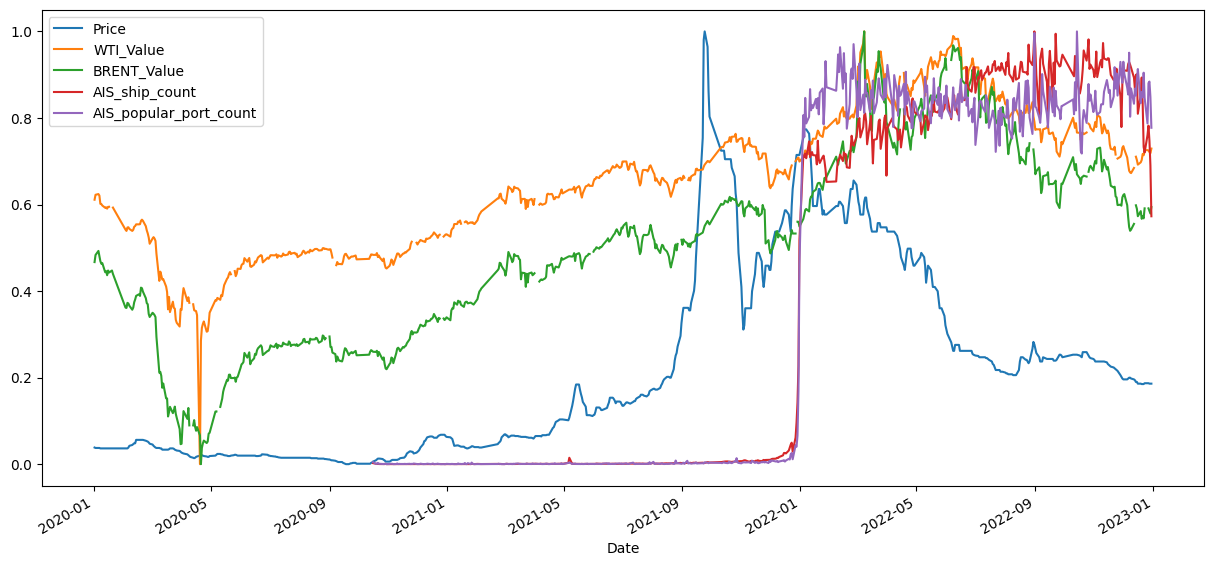

In [ ]:
# Join all the dataframes based on date
# Soecify suffix
combined_dataframe = price_dataframe.join(wti_petrol_dataframe.add_prefix('WTI_'), how='outer').join(brent_petrol_dataframe.add_prefix('BRENT_'), how='outer').join(volza_dataframe.add_prefix('VOLZA_'), how='outer').join(ais_popular_dataframe.add_prefix('AIS_'), how='outer')
combined_dataframe = combined_dataframe = combined_dataframe[combined_dataframe['Price'].notna()]


# Graph the combined dataframe where the min and max values are normalized
# Only get dates from 2020 onwards
graph_dataframe = (combined_dataframe - combined_dataframe.min()) / (combined_dataframe.max() - combined_dataframe.min())
graph_dataframe.drop(['spikes', 'VOLZA_Std. Quantity (POUND)', 'VOLZA_Std. Unit Rate ($/POUND)'], axis=1, inplace=True)
graph_dataframe.plot(figsize=(15, 7))

## **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Split combine dataframe into training and testing set
# 80% training and 20% testing
# Shuffle is set to False to ensure that the data is split in a way that the training data comes before the testing data
train, test = train_test_split(combined_dataframe.sort_index(), test_size=0.2, shuffle=False)

### **Ensure there is no temporal intermixing in data**

In [ ]:
def has_temporal_intermixing(train, test):
    """
    Check if the training and testing sets have temporal intermixing
    """
    return train.index.max() > test.index.min() 

has_temporal_intermixing(train, test)

False